In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

from auxiliary import plot_cm, plot_nn_loss, plot_nn_metrics, plot_roc, save_metrics, drop_var_nonobj, drop_var_obj

import os
import tempfile

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
#Change path according to directory used
df = pd.read_csv(r'C:\Users\henri\OneDrive\Documentos\EDSA\EDS Bootcamp\Project\Data\HR_DS.csv')

In [3]:
# Remove non object variables with no variability
drop_var_nonobj(df)

2 columns, ['EmployeeCount', 'StandardHours'] were droped


In [4]:
# Remove object variables with no variability
drop_var_obj(df)

The ['Over18'] column was droped.


In [5]:
objects = df.describe(include='O').columns.tolist()
non_objs = df.describe().columns.tolist()

patterns = [' ', 'Travel_', '-', '&']

for p in patterns:
    df[objects] = df[objects].apply(lambda x: x.str.replace(p, ''))
    print('Pattern "{}" cleared.'.format(p))

Pattern " " cleared.
Pattern "Travel_" cleared.
Pattern "-" cleared.
Pattern "&" cleared.


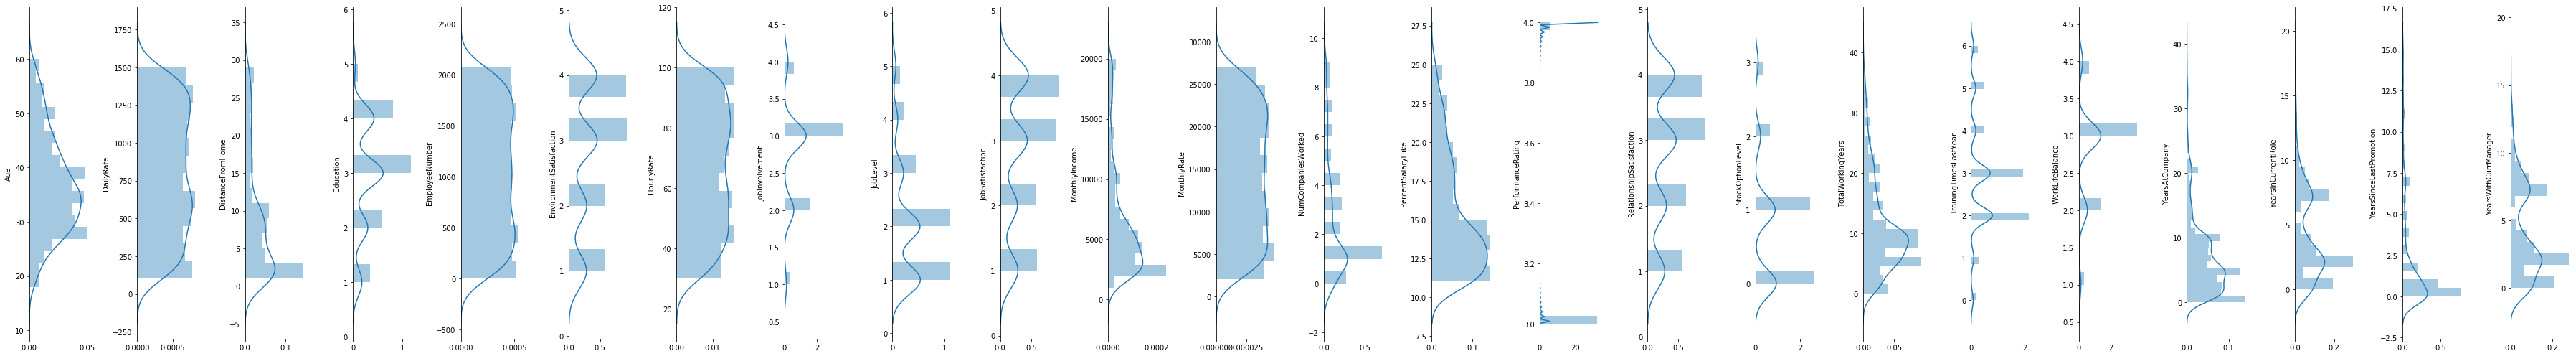

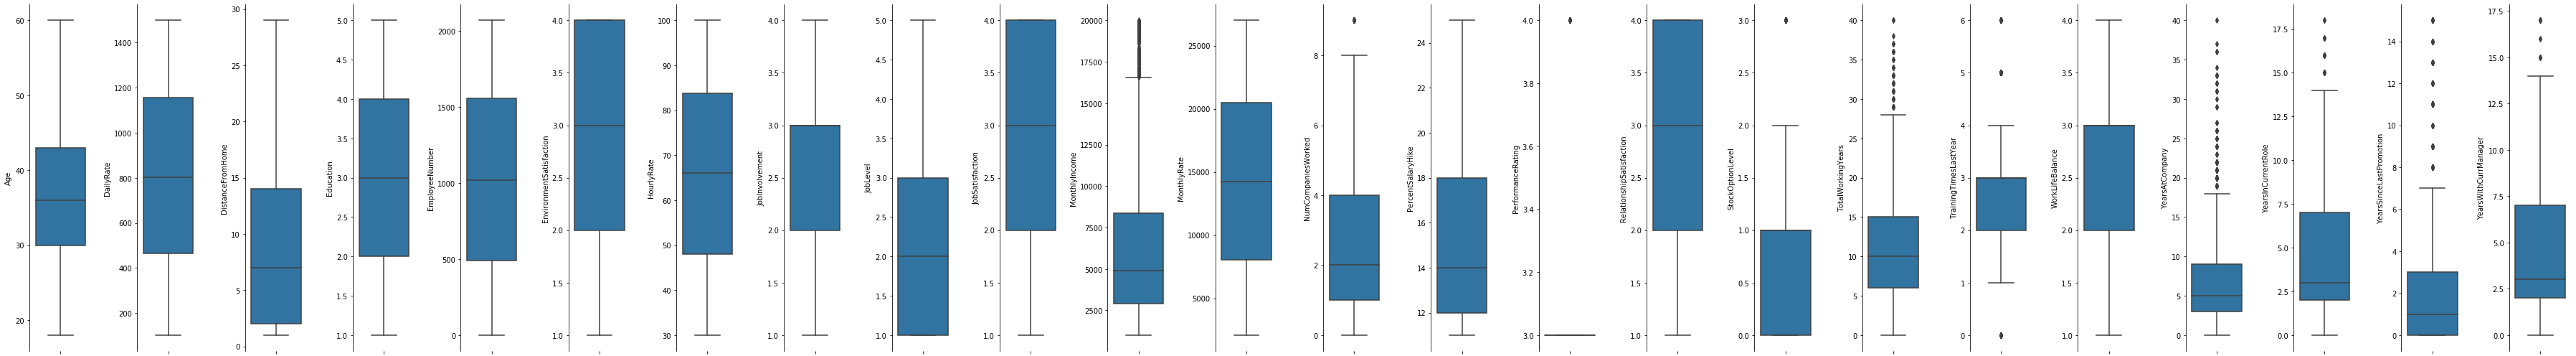

In [6]:
fig, axes = plt.subplots(ncols=len(non_objs), figsize=(50,7))
for ax, col in zip(axes, df[non_objs]):
    sb.distplot(df[col], ax=ax, vertical=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
plt.show()

fig, axes = plt.subplots(ncols=len(non_objs), figsize=(50,7))
for ax, col in zip(axes, df[non_objs]):
    sb.boxplot(df[col], ax=ax, orient='v')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
plt.show()

In [7]:
minmax = MinMaxScaler()
df_pre_ss = pd.concat([df[objects], pd.DataFrame(minmax.fit_transform(df[non_objs]), columns=df[non_objs].columns)], axis=1, sort=False)

Making some dummies

In [8]:
finaldf = pd.get_dummies(df_pre_ss, drop_first=True)

# Models Testing
First, the dataset has to be split into 3 sets of data so that the following is available for every model:
* A train dataset (features and labels appart) (60%)
* A validation dataset (features and labels appart) (20%)
    * Will be used to validate the train dataset
* A test dataset (features and labels appart) (20%)
    * Will be used to test the final models as an out of sample dataset.

In [9]:
# test 20%; val 20%; train 60%
train_df, test_df = train_test_split(finaldf, test_size=0.2, random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

# Form np arrays of labels and features
train_labels = np.array(train_df.pop('Attrition_Yes'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Attrition_Yes'))
test_labels = np.array(test_df.pop('Attrition_Yes'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)
print('')
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (940,)
Validation labels shape: (236,)
Test labels shape: (294,)

Training features shape: (940, 45)
Validation features shape: (236, 45)
Test features shape: (294, 45)


A check on the imbalance of the datasets is needed

In [10]:
# TODO CHECK ALL OTHER SPLITS
neg, pos = np.bincount(finaldf.Attrition_Yes)
total = neg + pos
print('Cases on dataset:\n    Total: {}\n    Employees that Left the company: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Cases on dataset:
    Total: 1470
    Employees that Left the company: 237 (16.12% of total)



A determination of the weights of the target label will be important further on the testing of the models

In [11]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2
weight_for_1 = (1 / pos)*(total)/2

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (Stayers): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (Leavers): {:.2f}'.format(weight_for_1))

Weight for class 0 (Stayers): 0.60
Weight for class 1 (Leavers): 3.10


In [12]:
# initialization of the dataframe to store the metrics for each model evaluated
models_summary = pd.DataFrame(columns=['model','tp', 'fp', 'tn', 'fn', 'acc', 'prec', 'recall', 'auc', 'f1'])

## 1. Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression as LR

Gridsearch:

In [14]:
m_log = LR(class_weight=class_weights,
                     random_state=0,
                     multi_class='ovr')

parameters = [{'solver' : ['sag'],
              'C' : [1, 10, 100, 1000],
              'max_iter': [100, 500, 1000, 10000],
              'penalty' : ('none', 'l2'),
              'warm_start' : (True, False)},
              {'solver' : ['liblinear', 'saga'], 
              'C' : [1, 10, 100, 1000],
              'max_iter': [100, 500, 1000, 10000],
              'penalty' : ('l1', 'l2'),
              'warm_start' : (True, False)}]
grid_s = sklearn.model_selection.GridSearchCV(m_log, parameters, cv=10, refit=True, n_jobs=-1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_logistic = grid_s.best_estimator_

LogisticRegression(C=1,
                   class_weight={0: 0.5961070559610706, 1: 3.10126582278481},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='ovr', n_jobs=None,
                   penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=True)


In [33]:
models_summary = save_metrics(models_summary, model_logistic, val_labels, model_logistic.predict(val_features))
models_summary
#print(metrics.classification_report(model_logistic.predict(val_features), val_labels))

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1
0,"LogisticRegression(C=1,\n cl...",32,51,143,10,0.741525,0.385542,0.761905,0.749509,0.512
1,"LogisticRegression(C=1,\n cl...",32,51,143,10,0.741525,0.385542,0.761905,0.749509,0.512


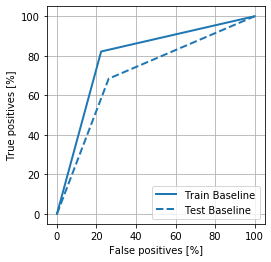

In [16]:
plot_roc("Log Train", train_labels, model_logistic.predict(train_features), color=colors[0])
plot_roc("Log Test", test_labels, model_logistic.predict(test_features), color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

Stayers Detected (True Negatives):  143
Leavers Incorrectly Detected (False Positives):  51
Stayers Incorrectly Detected (False Negatives):  10
Leavers Detected (True Positives):  32


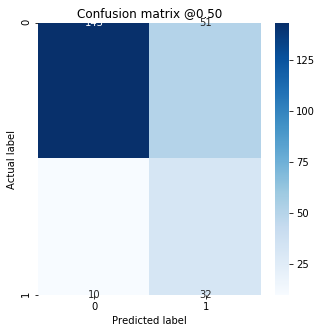

In [17]:
plot_cm(val_labels, model_logistic.predict(val_features))

## 2. LinearSVC

In [19]:
from sklearn.svm import LinearSVC as LSVC

GridSearch:

In [29]:
m_LinearSVC = LSVC(dual=False, 
                   tol=0.0001, 
                   multi_class='ovr', 
                   fit_intercept=True, 
                   intercept_scaling=1, 
                   class_weight=class_weights, 
                   random_state=0)

parameters = [{'C':[1,10,100,1000],
               'penalty' : ['l1', 'l2'],
               'max_iter': [100, 500, 1000, 10000, 100000, 1000000],
               'loss': ['squared_hinge']}]

grid_s = sklearn.model_selection.GridSearchCV(m_LinearSVC, parameters, cv=10, refit=True, n_jobs=-1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_LinearSVC = grid_s.best_estimator_

LinearSVC(C=10, class_weight={0: 0.5961070559610706, 1: 3.10126582278481},
          dual=False, fit_intercept=True, intercept_scaling=1,
          loss='squared_hinge', max_iter=500, multi_class='ovr', penalty='l1',
          random_state=0, tol=0.0001, verbose=0)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [34]:
models_summary = save_metrics(models_summary, model_LinearSVC, val_labels, model_LinearSVC.predict(val_features))
models_summary

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1
0,"LogisticRegression(C=1,\n cl...",32,51,143,10,0.741525,0.385542,0.761905,0.749509,0.512000
1,"LogisticRegression(C=1,\n cl...",32,51,143,10,0.741525,0.385542,0.761905,0.749509,0.512000
2,"LinearSVC(C=10, class_weight={0: 0.59610705596...",32,53,141,10,0.733051,0.376471,0.761905,0.744354,0.503937


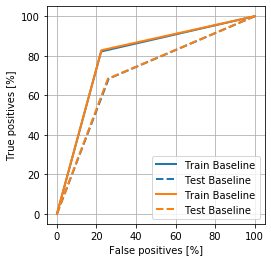

In [35]:
plot_roc("Log Train", train_labels, model_logistic.predict(train_features), color=colors[0])
plot_roc("Log Test", test_labels, model_logistic.predict(test_features), color=colors[0], linestyle='--')

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.predict(train_features), color=colors[1])
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.predict(test_features), color=colors[1], linestyle='--')
plt.legend(loc='lower right')
plt.show()

Stayers Detected (True Negatives):  190
Leavers Incorrectly Detected (False Positives):  66
Stayers Incorrectly Detected (False Negatives):  12
Leavers Detected (True Positives):  26


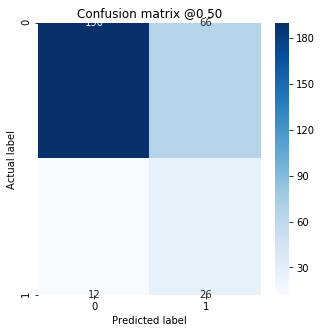

In [211]:
plot_cm(test_labels, model_LinearSVC.predict(test_features))

## 3. SVC

In [38]:
from sklearn.svm import SVC

In [48]:
m_SVC = SVC(probability=True, 
            tol=0.001, 
            cache_size=200,
            decision_function_shape='ovr',
            class_weight=class_weights,
            random_state=0,
            max_iter=5000)

parameters = [{'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'],
               'C' : [1,10,100],
               'gamma' : [1, 0.1, 0.001],
               'coef0' : [1, 0.1, 0.001],
               'shrinking' : [True, False]}]

grid_s = sklearn.model_selection.GridSearchCV(m_SVC, parameters, cv=10, refit=True, n_jobs=-1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_SVC = grid_s.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=1, cache_size=200,
    class_weight={0: 0.5961070559610706, 1: 3.10126582278481}, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
    max_iter=5000, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


In [49]:
models_summary = save_metrics(models_summary, model_SVC, val_labels, model_SVC.predict(val_features))
models_summary

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1
0,"LogisticRegression(C=1,\n cl...",32,51,143,10,0.741525,0.385542,0.761905,0.749509,0.512000
1,"LogisticRegression(C=1,\n cl...",32,51,143,10,0.741525,0.385542,0.761905,0.749509,0.512000
2,"LinearSVC(C=10, class_weight={0: 0.59610705596...",32,53,141,10,0.733051,0.376471,0.761905,0.744354,0.503937
3,"SVC(C=1, cache_size=200,\n class_weight={0:...",1,0,194,41,0.826271,1.000000,0.023810,0.511905,0.046512


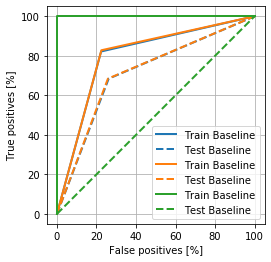

In [50]:
plot_roc("Log Train", train_labels, model_logistic.predict(train_features), color=colors[0])
plot_roc("Log Test", test_labels, model_logistic.predict(test_features), color=colors[0], linestyle='--')

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.predict(train_features), color=colors[1])
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.predict(test_features), color=colors[1], linestyle='--')

plot_roc("SVC Train", train_labels, model_SVC.predict(train_features), color=colors[2])
plot_roc("SVC Test", test_labels, model_SVC.predict(test_features), color=colors[2], linestyle='--')
plt.legend(loc='lower right')
plt.show()

Stayers Detected (True Negatives):  256
Leavers Incorrectly Detected (False Positives):  0
Stayers Incorrectly Detected (False Negatives):  38
Leavers Detected (True Positives):  0


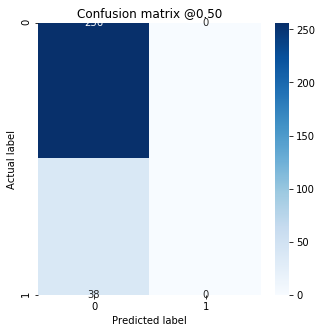

In [212]:
plot_cm(test_labels, model_SVC.predict(test_features))

## 4. Radius Neighbors Classifier

In [52]:
from sklearn.neighbors import RadiusNeighborsClassifier as RadiusNC

In [70]:
m_RadiusNC = RadiusNC(n_jobs=-1)

parameters = [{'radius' : [i for i in range(10,50)],
               'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
               'weights' : ['uniform', 'distance'],
               'p' : [1, 2, 3]}]

grid_s = sklearn.model_selection.GridSearchCV(m_RadiusNC, parameters, cv=10, refit=True, n_jobs=-1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_RadiusNC = grid_s.best_estimator_

RadiusNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
                          metric='minkowski', metric_params=None, n_jobs=-1,
                          outlier_label=None, p=1, radius=10,
                          weights='distance')


In [71]:
models_summary = save_metrics(models_summary, model_RadiusNC, val_labels, model_RadiusNC.predict(val_features))
models_summary

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1
0,"LogisticRegression(C=1,\n cl...",32,51,143,10,0.741525,0.385542,0.761905,0.749509,0.512000
1,"LogisticRegression(C=1,\n cl...",32,51,143,10,0.741525,0.385542,0.761905,0.749509,0.512000
2,"LinearSVC(C=10, class_weight={0: 0.59610705596...",32,53,141,10,0.733051,0.376471,0.761905,0.744354,0.503937
3,"SVC(C=1, cache_size=200,\n class_weight={0:...",1,0,194,41,0.826271,1.000000,0.023810,0.511905,0.046512
4,RadiusNeighborsClassifier(algorithm='ball_tree...,2,0,194,40,0.830508,1.000000,0.047619,0.523810,0.090909


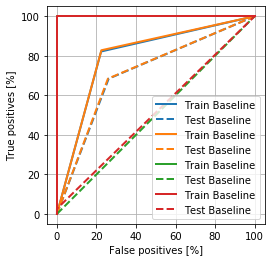

In [72]:
plot_roc("Log Train", train_labels, model_logistic.predict(train_features), color=colors[0])
plot_roc("Log Test", test_labels, model_logistic.predict(test_features), color=colors[0], linestyle='--')

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.predict(train_features), color=colors[1])
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.predict(test_features), color=colors[1], linestyle='--')

plot_roc("SVC Train", train_labels, model_SVC.predict(train_features), color=colors[2])
plot_roc("SVC Test", test_labels, model_SVC.predict(test_features), color=colors[2], linestyle='--')

plot_roc("RadiusNC Train", train_labels, model_RadiusNC.predict(train_features), color=colors[3])
plot_roc("RadiusNC Test", test_labels, model_RadiusNC.predict(test_features), color=colors[3], linestyle='--')
plt.legend(loc='lower right')
plt.show()

Stayers Detected (True Negatives):  256
Leavers Incorrectly Detected (False Positives):  0
Stayers Incorrectly Detected (False Negatives):  37
Leavers Detected (True Positives):  1


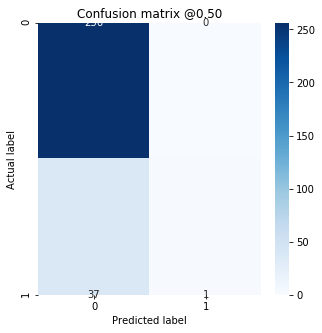

In [213]:
plot_cm(test_labels, model_RadiusNC.predict(test_features))

## 5. Random Forest Classifier

In [74]:
from sklearn.ensemble import RandomForestClassifier as RForest

In [76]:
m_RF = RForest(criterion='gini',
               n_jobs=-1,
               random_state=0)

parameters = [{'n_estimators' : [i for i in range(0,500,100)],
               'max_depth' : [i for i in range(0,100,50)],
              'min_samples_leaf' : [2, 5],
              'max_features' : ['auto'],
              'warm_start' : [True, False], 
              'class_weight' : [class_weights, 'balanced_subsample']}]

grid_s = sklearn.model_selection.GridSearchCV(m_RF, parameters, cv=10, refit=True, n_jobs=-1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_RandomForest = grid_s.best_estimator_

RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.5961070559610706,
                                     1: 3.10126582278481},
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=True)


In [77]:
models_summary = save_metrics(models_summary, model_RandomForest, val_labels, model_RandomForest.predict(val_features))
models_summary

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1
0,"LogisticRegression(C=1,\n cl...",32,51,143,10,0.741525,0.385542,0.761905,0.749509,0.512000
1,"LogisticRegression(C=1,\n cl...",32,51,143,10,0.741525,0.385542,0.761905,0.749509,0.512000
2,"LinearSVC(C=10, class_weight={0: 0.59610705596...",32,53,141,10,0.733051,0.376471,0.761905,0.744354,0.503937
3,"SVC(C=1, cache_size=200,\n class_weight={0:...",1,0,194,41,0.826271,1.000000,0.023810,0.511905,0.046512
4,RadiusNeighborsClassifier(algorithm='ball_tree...,2,0,194,40,0.830508,1.000000,0.047619,0.523810,0.090909
5,"(DecisionTreeClassifier(class_weight=None, cri...",4,0,194,38,0.838983,1.000000,0.095238,0.547619,0.173913


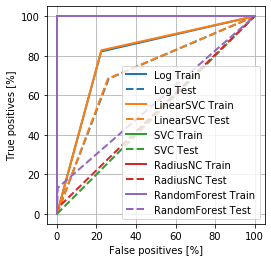

In [78]:
plot_roc("Log Train", train_labels, model_logistic.predict(train_features), color=colors[0])
plot_roc("Log Test", test_labels, model_logistic.predict(test_features), color=colors[0], linestyle='--')

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.predict(train_features), color=colors[1])
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.predict(test_features), color=colors[1], linestyle='--')

plot_roc("SVC Train", train_labels, model_SVC.predict(train_features), color=colors[2])
plot_roc("SVC Test", test_labels, model_SVC.predict(test_features), color=colors[2], linestyle='--')

plot_roc("RadiusNC Train", train_labels, model_RadiusNC.predict(train_features), color=colors[3])
plot_roc("RadiusNC Test", test_labels, model_RadiusNC.predict(test_features), color=colors[3], linestyle='--')

plot_roc("RandomForest Train", train_labels, model_RandomForest.predict(train_features), color=colors[4])
plot_roc("RandomForest Test", test_labels, model_RandomForest.predict(test_features), color=colors[4], linestyle='--')
plt.legend(loc='lower right')
plt.show()

Stayers Detected (True Negatives):  255
Leavers Incorrectly Detected (False Positives):  1
Stayers Incorrectly Detected (False Negatives):  33
Leavers Detected (True Positives):  5


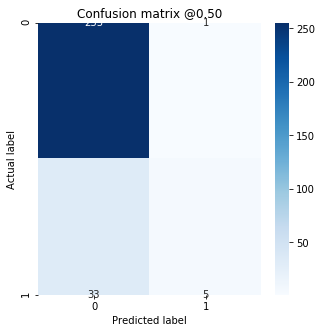

In [214]:
plot_cm(test_labels, model_RandomForest.predict(test_features))

## 5. Keras Tensorflow Classification NN

In [80]:
import tensorflow as tf
from tensorflow import keras

In [529]:
METRICS = [
            keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'), 
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(30, activation='relu', input_shape=(train_features.shape[-1],)),
      #keras.layers.Dropout(0.5),
      keras.layers.Dense(20, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(10, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(5, activation='relu'),
      #keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias), # sigmoid for probability output
  ])

    # Designing NN:
    # https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    
  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-2),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [530]:
EPOCHS = 1000
BATCH_SIZE = 50

# use other callbacks!?!?!?!?!?
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [531]:
model_keras = make_model()
model_keras.summary()

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_544 (Dense)            (None, 30)                1380      
_________________________________________________________________
dense_545 (Dense)            (None, 20)                620       
_________________________________________________________________
dropout_212 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_546 (Dense)            (None, 10)                210       
_________________________________________________________________
dropout_213 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_547 (Dense)            (None, 5)                 55        
_________________________________________________________________
dense_548 (Dense)            (None, 1)              

In [532]:
#Loss without correct initialization of bias
results = model_keras.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

KeyboardInterrupt: 

In [ ]:
#Loss with correct initialization of bias
initial_bias = np.log([pos/neg])
model_keras = make_model(output_bias = initial_bias)

results = model_keras.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

In [ ]:
#saving correct bias
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model_keras.save_weights(initial_weights)

In [ ]:
model_keras = make_model()
model_keras.load_weights(initial_weights)
baseline_history = model_keras.fit(train_features,
                                    train_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    callbacks = [early_stopping],
                                    validation_data=(val_features, val_labels))

In [ ]:
plot_nn_metrics(baseline_history)

In [521]:
train_predictions_baseline = model_keras.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model_keras.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.3855904614438816
tp :  0.0
fp :  0.0
tn :  256.0
fn :  38.0
accuracy :  0.8707483
precision :  0.0
recall :  0.0
auc :  0.62386924

Stayers Detected (True Negatives):  256
Leavers Incorrectly Detected (False Positives):  0
Stayers Incorrectly Detected (False Negatives):  38
Leavers Detected (True Positives):  0


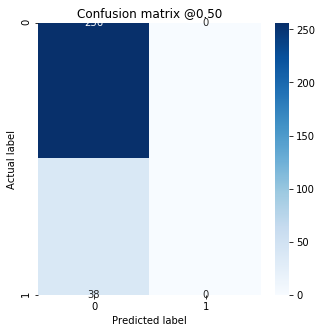

In [522]:
baseline_results = model_keras.evaluate(test_features, 
                                        test_labels,
                                        batch_size=BATCH_SIZE, 
                                        verbose=0)
for name, value in zip(model_keras.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

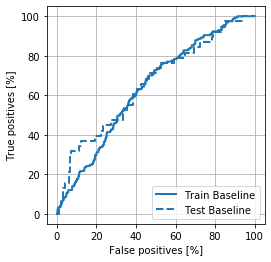

In [523]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [524]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weights) 

Train on 940 samples, validate on 236 samples
Epoch 1/1000
940/940 [==============================] - 7s 7ms/sample - loss: 1.0294 - tp: 0.0000e+00 - fp: 1.0000 - tn: 782.0000 - fn: 157.0000 - accuracy: 0.8319 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4919 - val_loss: 0.4737 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 194.0000 - val_fn: 42.0000 - val_accuracy: 0.8220 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4137
Epoch 2/1000
940/940 [==============================] - 0s 181us/sample - loss: 0.9818 - tp: 0.0000e+00 - fp: 12.0000 - tn: 771.0000 - fn: 157.0000 - accuracy: 0.8202 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4603 - val_loss: 0.4804 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 194.0000 - val_fn: 42.0000 - val_accuracy: 0.8220 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4165
Epoch 3/1000
940/940 [==============================] - 0s 184us/sample - loss: 0.9324 - tp: 6.0000 - fp: 34.0000 - tn: 7

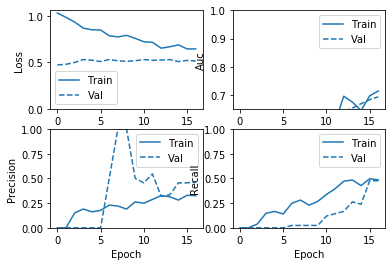

In [525]:
plot_nn_metrics(weighted_history)

In [526]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.48924526410037966
tp :  0.0
fp :  2.0
tn :  254.0
fn :  38.0
accuracy :  0.8639456
precision :  0.0
recall :  0.0
auc :  0.6147204

Stayers Detected (True Negatives):  254
Leavers Incorrectly Detected (False Positives):  2
Stayers Incorrectly Detected (False Negatives):  38
Leavers Detected (True Positives):  0


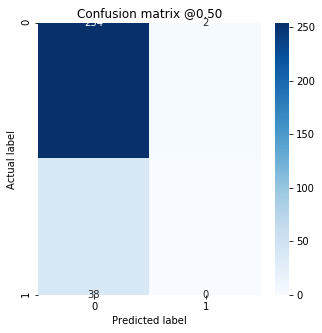

In [527]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

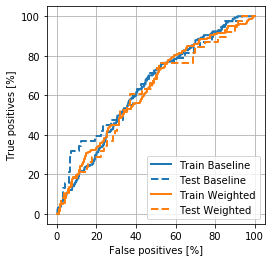

In [528]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [503]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [504]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(783, 45)

In [505]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(1566, 45)

In [506]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [507]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

50.0

In [508]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/1000
50/50 [==============================] - 10s 206ms/step - loss: 1.0293 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1272.0000 - fn: 1228.0000 - accuracy: 0.5088 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5140 - val_loss: 0.4731 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 194.0000 - val_fn: 42.0000 - val_accuracy: 0.8220 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3867
Epoch 2/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.8703 - tp: 52.0000 - fp: 57.0000 - tn: 1196.0000 - fn: 1195.0000 - accuracy: 0.4992 - precision: 0.4771 - recall: 0.0417 - auc: 0.5047 - val_loss: 0.5311 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 194.0000 - val_fn: 42.0000 - val_accuracy: 0.8220 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4334
Epoch 3/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.8047 - tp: 216.0000 - fp: 190.0000 - tn: 1053.0000 - fn: 1041.0000 - accuracy: 0.5076 - precision: 0.

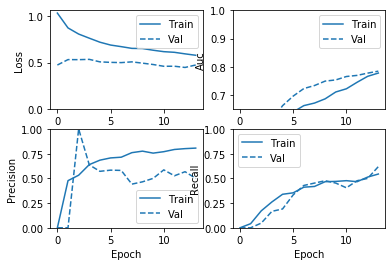

In [509]:
plot_nn_metrics(resampled_history)

In [510]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.48377360352853527
tp :  6.0
fp :  2.0
tn :  254.0
fn :  32.0
accuracy :  0.88435376
precision :  0.75
recall :  0.15789473
auc :  0.7781662

Stayers Detected (True Negatives):  255
Leavers Incorrectly Detected (False Positives):  1
Stayers Incorrectly Detected (False Negatives):  38
Leavers Detected (True Positives):  0


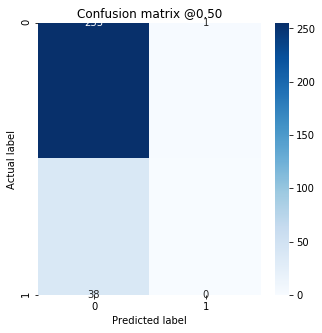

In [511]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

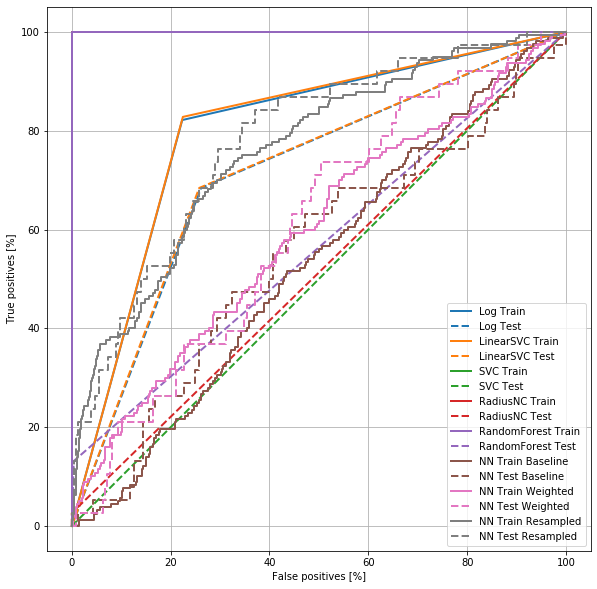

In [512]:
fig = plt.figure(figsize=(10,10))
plot_roc("Log Train", train_labels, model_logistic.predict(train_features), color=colors[0])
plot_roc("Log Test", test_labels, model_logistic.predict(test_features), color=colors[0], linestyle='--')

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.predict(train_features), color=colors[1])
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.predict(test_features), color=colors[1], linestyle='--')

plot_roc("SVC Train", train_labels, model_SVC.predict(train_features), color=colors[2])
plot_roc("SVC Test", test_labels, model_SVC.predict(test_features), color=colors[2], linestyle='--')

plot_roc("RadiusNC Train", train_labels, model_RadiusNC.predict(train_features), color=colors[3])
plot_roc("RadiusNC Test", test_labels, model_RadiusNC.predict(test_features), color=colors[3], linestyle='--')

plot_roc("RandomForest Train", train_labels, model_RandomForest.predict(train_features), color=colors[4])
plot_roc("RandomForest Test", test_labels, model_RandomForest.predict(test_features), color=colors[4], linestyle='--')

plot_roc("NN Train Baseline", train_labels, train_predictions_baseline, color=colors[5])
plot_roc("NN Test Baseline", test_labels, test_predictions_baseline, color=colors[5], linestyle='--')

plot_roc("NN Train Weighted", train_labels, train_predictions_weighted, color=colors[6])
plot_roc("NN Test Weighted", test_labels, test_predictions_weighted, color=colors[6], linestyle='--')

plot_roc("NN Train Resampled", train_labels, train_predictions_resampled,  color=colors[7])
plot_roc("NN Test Resampled", test_labels, test_predictions_resampled,  color=colors[7], linestyle='--')
plt.legend(loc='lower right')
plt.show()